In [1]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt

mesoamerica_detections_5 = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_mesoamerica_posw1.0_prob_0.5_postprocess.parquet")
mesoamerica_detections = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_mesoamerica_posw1.0_prob_0.9_postprocess.parquet")


In [3]:
crops = gpd.read_file("gs://demeter-labs/coffee/geometries/Mesoamerica_otherCrops_Final.geojson")
mesoamerica_polygons = crops[crops['crop'] == 'Coffee']
other_crops = crops[crops['crop'] != 'Coffee']

/tmp/ipykernel_2480001/2552640653.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesoamerica_polygons_union = mesoamerica_polygons.unary_union
/tmp/ipykernel_2480001/2552640653.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesoamerica_detections_union = mesoamerica_detections.unary_union
/tmp/ipykernel_2480001/2552640653.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesoamerica_detections_5_union = mesoamerica_detections_5.unary_union


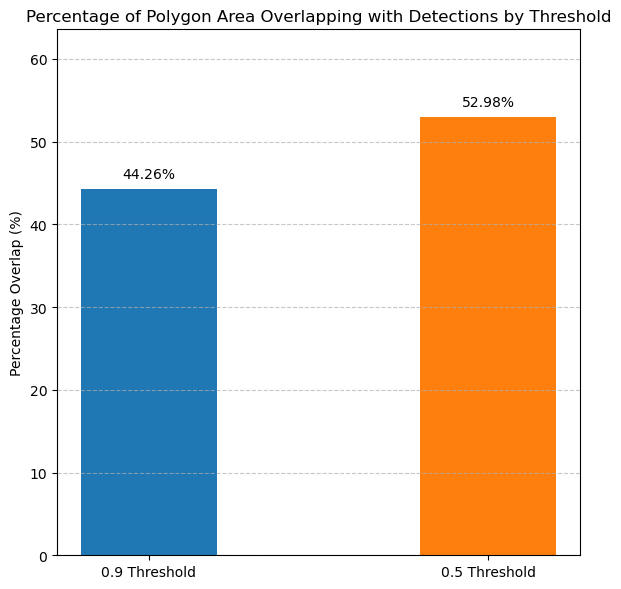

In [4]:
import pandas as pd

# Calculate unary unions
mesoamerica_polygons_union = mesoamerica_polygons.unary_union
mesoamerica_detections_union = mesoamerica_detections.unary_union
mesoamerica_detections_5_union = mesoamerica_detections_5.unary_union

# Calculate intersection areas
intersection_09 = mesoamerica_polygons_union.intersection(mesoamerica_detections_union)
intersection_05 = mesoamerica_polygons_union.intersection(mesoamerica_detections_5_union)

# Calculate areas
mesoamerica_area = mesoamerica_polygons_union.area
intersection_09_area = intersection_09.area
intersection_05_area = intersection_05.area

# Calculate overlap percentages
pct_overlap_09 = (intersection_09_area / mesoamerica_area) * 100
pct_overlap_05 = (intersection_05_area / mesoamerica_area) * 100

# Create bar chart with thinner bars
fig, ax = plt.figure(figsize=(6, 6)), plt.gca()
thresholds = ['0.9 Threshold', '0.5 Threshold']
percentages = [pct_overlap_09, pct_overlap_05]
bars = ax.bar(thresholds, percentages, color=['#1f77b4', '#ff7f0e'], width=0.4)

# Add data labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.2f}%',
            ha='center', va='bottom')

# Add chart labels
ax.set_title('Percentage of Polygon Area Overlapping with Detections by Threshold')
ax.set_ylabel('Percentage Overlap (%)')
ax.set_ylim(0, max(percentages) * 1.2)  # Add some space for the labels
ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Add text with total area
# ax.text(0.02, 0.95, f'Total polygon area: {mesoamerica_area:.2f} sq units', transform=ax.transAxes,
#         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

Total number of polygons: 10251
Polygons with no intersection at 0.9 threshold: 2532 (24.70%)
Polygons with no intersection at 0.5 threshold: 1742 (16.99%)


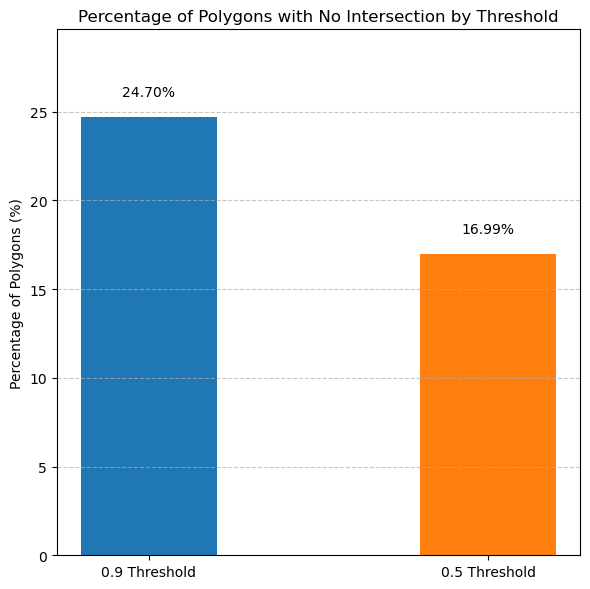

In [10]:
# Use geopandas spatial operations to find polygons with no intersections
total_polygons = len(mesoamerica_polygons)

# For 0.9 threshold - find polygons that intersect with any detection
intersecting_09 = gpd.sjoin(mesoamerica_polygons, mesoamerica_detections, predicate='intersects', how='inner')
# Count unique polygons that have an intersection
intersecting_polygons_09 = intersecting_09.index.unique()
# Calculate non-intersecting polygons
no_intersection_count_09 = total_polygons - len(intersecting_polygons_09)

# For 0.5 threshold - find polygons that intersect with any detection
intersecting_05 = gpd.sjoin(mesoamerica_polygons, mesoamerica_detections_5, predicate='intersects', how='inner')
# Count unique polygons that have an intersection
intersecting_polygons_05 = intersecting_05.index.unique()
# Calculate non-intersecting polygons
no_intersection_count_05 = total_polygons - len(intersecting_polygons_05)

# Display results
print(f"Total number of polygons: {total_polygons}")
print(f"Polygons with no intersection at 0.9 threshold: {no_intersection_count_09} ({no_intersection_count_09/total_polygons*100:.2f}%)")
print(f"Polygons with no intersection at 0.5 threshold: {no_intersection_count_05} ({no_intersection_count_05/total_polygons*100:.2f}%)")
# Create bar chart for polygon intersection results
fig, ax = plt.figure(figsize=(6, 6)), plt.gca()
thresholds = ['0.9 Threshold', '0.5 Threshold']
percentages = [
    (no_intersection_count_09/total_polygons*100),
    (no_intersection_count_05/total_polygons*100)
]

bars = ax.bar(thresholds, percentages, color=['#1f77b4', '#ff7f0e'], width=0.4)

# Add data labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.2f}%',
            ha='center', va='bottom')

# Add chart labels
ax.set_title('Percentage of Polygons with No Intersection by Threshold')
ax.set_ylabel('Percentage of Polygons (%)')
ax.set_ylim(0, max(percentages) * 1.2)  # Add some space for the labels
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()


In [5]:
import shapely
import pandas as pd
unique_crops = other_crops['crop'].unique()

# Create a dataframe to store results
overlap_results = []

# Process each crop
for crop in unique_crops:
    # Filter for this crop
    crop_data = other_crops[other_crops['crop'] == crop]
    
    # Convert to regular polygons (remove Z dimension)
    # Handle both Polygon and MultiPolygon geometries
    def convert_geometry(geom):
        if isinstance(geom, shapely.geometry.MultiPolygon):
            # Process each polygon in the multipolygon
            polygons = []
            for poly in geom.geoms:
                polygons.append(shapely.geometry.Polygon([(p[0], p[1]) for p in poly.exterior.coords]))
            return shapely.geometry.MultiPolygon(polygons)
        else:
            # Process single polygon
            return shapely.geometry.Polygon([(p[0], p[1]) for p in geom.exterior.coords])
    
    crop_data['geometry'] = crop_data['geometry'].apply(convert_geometry)
    
    # Create unary union
    crop_union = crop_data.unary_union
    
    # Calculate intersection areas
    intersection_09 = crop_union.intersection(mesoamerica_detections_union)
    intersection_05 = crop_union.intersection(mesoamerica_detections_5_union)
    
    # Calculate areas
    crop_area = crop_union.area
    intersection_09_area = intersection_09.area
    intersection_05_area = intersection_05.area
    
    # Calculate overlap percentages
    pct_overlap_09 = (intersection_09_area / crop_area) * 100 if crop_area > 0 else 0
    pct_overlap_05 = (intersection_05_area / crop_area) * 100 if crop_area > 0 else 0
    
    # Add to results
    overlap_results.append({
        'crop': crop,
        'area_ha': crop_data['Area_ha'].sum(),
        'pct_overlap_09': pct_overlap_09,
        'pct_overlap_05': pct_overlap_05
    })

# Convert to dataframe and display
overlap_df = pd.DataFrame(overlap_results)
overlap_df.sort_values('area_ha', ascending=False, inplace=True)
overlap_df

/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_2480001/2484700601.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  crop_union = crop_data.unary_union
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

,crop,area_ha,pct_overlap_09,pct_overlap_05
2,Pineapple fruit,13121.736,0.000000,0.000000
6,Cocoa,12641.211,5.735339,8.117851
1,Banana,11340.478,0.000000,0.000000
3,Macadamia,8976.648,18.750823,27.831105
4,Avocado,3558.695,34.111057,42.263470
5,Mangosteen,3461.818,9.228071,14.930657
7,Melon fruit,2802.792,0.000000,0.007109
10,Plantain,2523.392,0.000000,0.000000
0,White Pepper,610.104,0.000000,0.000000
9,Cassava,210.263,0.000000,0.000000


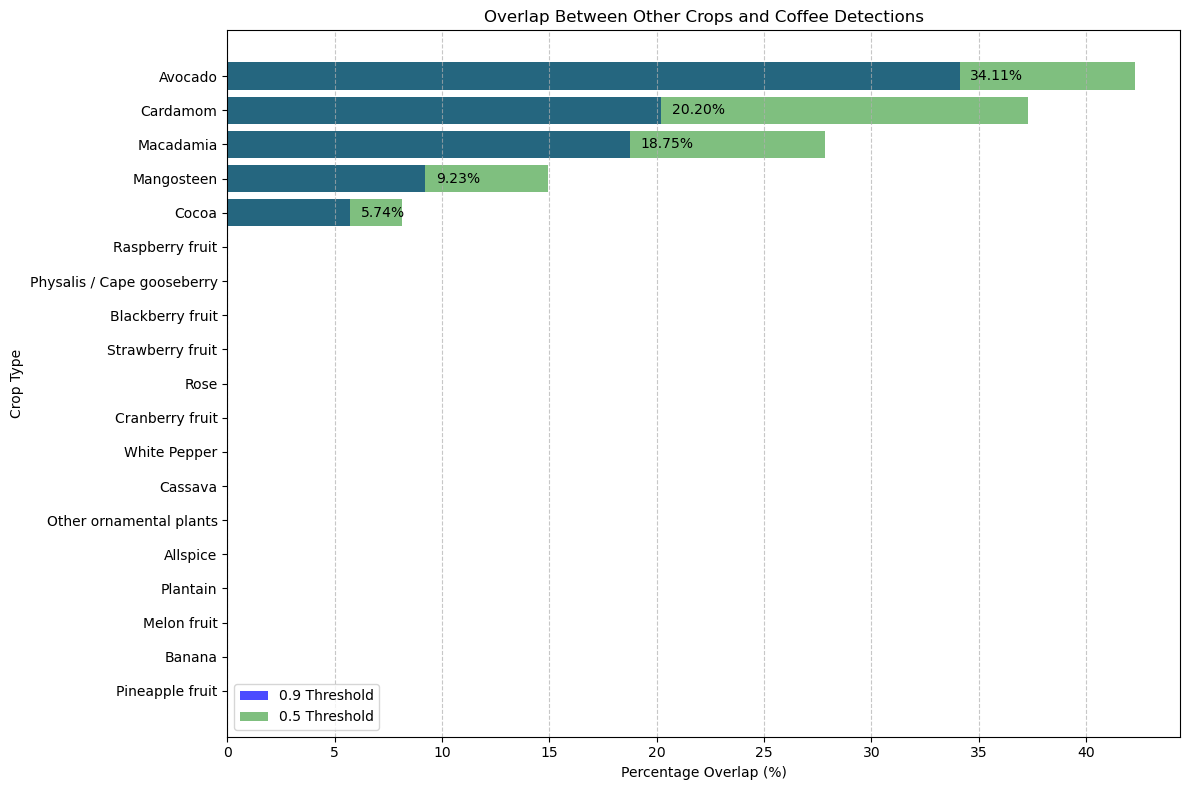

,crop,area_ha,pct_overlap_09,pct_overlap_05
2,Pineapple fruit,13121.736,0.000000,0.000000
6,Cocoa,12641.211,5.735339,8.117851
1,Banana,11340.478,0.000000,0.000000
3,Macadamia,8976.648,18.750823,27.831105
4,Avocado,3558.695,34.111057,42.263470
5,Mangosteen,3461.818,9.228071,14.930657
7,Melon fruit,2802.792,0.000000,0.007109
10,Plantain,2523.392,0.000000,0.000000
0,White Pepper,610.104,0.000000,0.000000
9,Cassava,210.263,0.000000,0.000000


In [6]:
# Create a copy of the dataframe for plotting
plot_df = overlap_df.copy()

# Sort by percentage overlap (using the 0.9 threshold values)
plot_df = plot_df.sort_values('pct_overlap_09', ascending=True)

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(plot_df['crop'], plot_df['pct_overlap_09'], color='blue', alpha=0.7, label='0.9 Threshold')
plt.barh(plot_df['crop'], plot_df['pct_overlap_05'], color='green', alpha=0.5, label='0.5 Threshold')

# Add labels and title
plt.xlabel('Percentage Overlap (%)')
plt.ylabel('Crop Type')
plt.title('Overlap Between Other Crops and Coffee Detections')
plt.legend()

# Add percentage values at the end of each bar for better readability
for i, bar in enumerate(bars):
    if plot_df.iloc[i]['pct_overlap_09'] > 0:
        plt.text(plot_df.iloc[i]['pct_overlap_09'] + 0.5, i, 
                 f"{plot_df.iloc[i]['pct_overlap_09']:.2f}%", 
                 va='center')

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Display the original dataframe as well
overlap_df

100%|██████████| 14/14 [01:13<00:00,  5.28s/it]


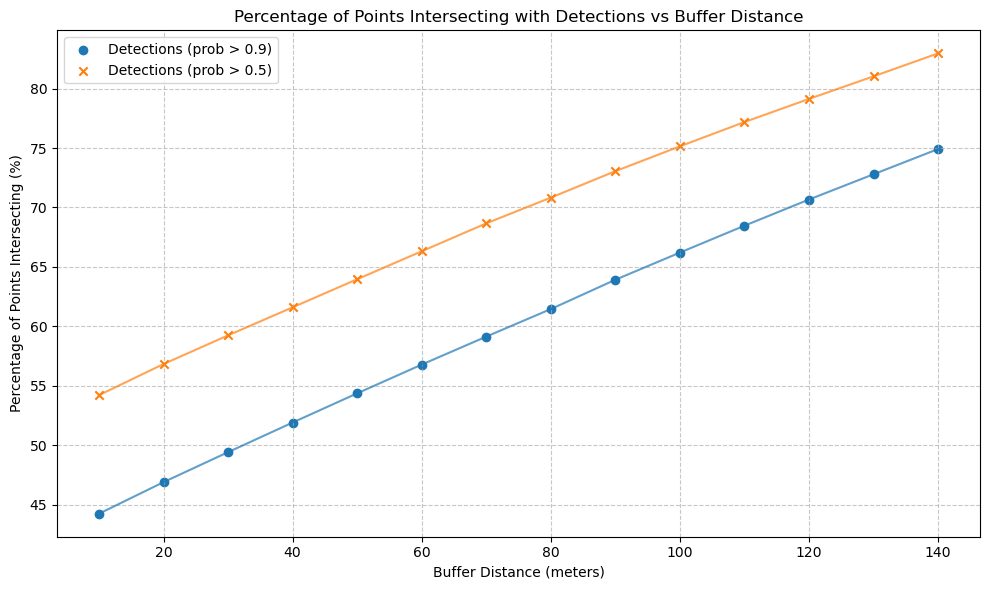

In [11]:
mesoamerica_points = gpd.read_file("gs://demeter-labs/tea/geometries/ra_data/subsets/central_america_coffee_points.geojson")

def buffer_points_in_utm(points_gdf, buffer_size=100):
    """
    Buffer points using appropriate UTM projection.
    
    Parameters:
        points_gdf (GeoDataFrame): GeoDataFrame containing point geometries
        buffer_size (float): Buffer size in meters
        
    Returns:
        GeoDataFrame: GeoDataFrame with buffered geometries
    """
    # Get the center of the bounds
    bounds = points_gdf.total_bounds
    center_lon = (bounds[0] + bounds[2]) / 2
    center_lat = (bounds[1] + bounds[3]) / 2
    
    # Calculate UTM zone from longitude
    utm_zone = int(((center_lon + 180) / 6) % 60) + 1
    
    # Determine if northern or southern hemisphere
    epsg = 32600 + utm_zone if center_lat >= 0 else 32700 + utm_zone
    
    # Project to UTM
    points_utm = points_gdf.to_crs(epsg=epsg)
    
    # Buffer the points
    buffered_points_utm = points_utm.copy()
    buffered_points_utm['geometry'] = points_utm.geometry.buffer(buffer_size)
    
    # Project back to original CRS
    buffered_points = buffered_points_utm.to_crs(points_gdf.crs)
    
    return buffered_points

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
# Create a range of buffer distances
buffer_distances = range(10, 150, 10)

# Lists to store results
percentages = []
percentages_5 = []

# Calculate intersection percentages for each buffer distance
for distance in tqdm(buffer_distances):
    # Buffer points with current distance
    buffered_points = buffer_points_in_utm(mesoamerica_points, buffer_size=distance)
    
    # Count intersections
    intersecting = buffered_points.sjoin(mesoamerica_detections, predicate='intersects', how='inner')
    intersecting_5 = buffered_points.sjoin(mesoamerica_detections_5, predicate='intersects', how='inner')
    
    # Calculate percentages
    percent = len(intersecting) / len(buffered_points) * 100
    percent_5 = len(intersecting_5) / len(buffered_points) * 100
    
    # Store results
    percentages.append(percent)
    percentages_5.append(percent_5)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(buffer_distances, percentages, label='Detections (prob > 0.9)', marker='o')
plt.scatter(buffer_distances, percentages_5, label='Detections (prob > 0.5)', marker='x')

# Connect points with lines
plt.plot(buffer_distances, percentages, linestyle='-', alpha=0.7)
plt.plot(buffer_distances, percentages_5, linestyle='-', alpha=0.7)

# Add labels and title
plt.xlabel('Buffer Distance (meters)')
plt.ylabel('Percentage of Points Intersecting (%)')
plt.title('Percentage of Points Intersecting with Detections vs Buffer Distance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

